In [50]:
from rdkit import Chem
import os

def load_smi(path_to_smi):
    """
    Load a .smi file and return a list with the molecules.
    Args:
        - path_to_smi : path to the .smi file
    Returns:
        - molecules : list with the molecules
    """
    molecules = []
    supplier = Chem.SmilesMolSupplier(path_to_smi,titleLine=False)
    for mol in supplier:
        if mol is not None:
            molecules.append(mol)
    return molecules

class MolLoader:
    '''
    Class to load molecules in .dat format.

    Args:
        - target_QAOA_path : path to the target molecules to be used in the QAOA challenge
        - candidate_QAOA_path : path to the candidate molecules to be used in the QAOA challenge
        - target_DA_path : path to the target molecules to be used in the DA challenge
        - candidate_DA_path : path to the candidate molecules to be used in the DA challenge

    Returns:
        - target_mols_dict : dictionary with the target molecules (keys: molecule names, values: RDKit molecule objects)
        - candidate_molecules_dict : dictionary with the candidate molecules (keys: molecule names, values: RDKit molecule objects)

    Example:
        `mol_loader = MolLoader()` \\
        `target_mols_dict, candidate_molecules_dict = mol_loader.load_molecules_QAOA()`
    '''
    def __init__(self,target_QAOA_path='data/target_molecules/target_molecule_QAOA.dat',
                 candidate_QAOA_path='data/candidates/candidate_molecules_QAOA.dat',
                 target_DA_path='data/target_molecules/target_molecule_DA.dat',
                 candidate_DA_path='data/candidates/candidate_molecules_DA.dat') -> None:
        self.target_QAOA_path = target_QAOA_path
        self.candidate_QAOA_path = candidate_QAOA_path
        self.target_DA_path = target_DA_path
        self.candidate_DA_path = candidate_DA_path
        
        
    def load_molecules_QAOA(self):
        with open(self.target_QAOA_path, 'r') as file:
            target_molecules_lines = file.readlines()
        target_mols_dict = {}
        for line in target_molecules_lines:
            if line[0] == '#':
                continue
            line = line.split()
            target_mols_dict[line[0]] = Chem.MolFromSmiles(line[2])

        with open(self.candidate_QAOA_path, 'r') as file:
            candidate_molecules_lines = file.readlines()
        candidate_molecules_dict = {}
        for line in candidate_molecules_lines:
            if line[0] == '#':
                continue
            line = line.split()
            candidate_molecules_dict[line[0]] = Chem.MolFromSmiles(line[2])
        return target_mols_dict, candidate_molecules_dict
    
    def load_target_QAOA(self):
        with open(self.target_QAOA_path, 'r') as file:
            target_molecules_lines = file.readlines()
        for line in target_molecules_lines:
            if line[0] == '#':
                continue
            line = line.split()
            return line[0],Chem.MolFromSmiles(line[2])
    
    def load_molecules_DA(self):
        with open(self.target_DA_path, 'r') as file:
            target_molecules_lines = file.readlines()
        target_mols_dict = {}
        for line in target_molecules_lines:
            if line[0] == '#':
                continue
            line = line.split()
            target_mols_dict[line[0]] = Chem.MolFromSmiles(line[2])

        with open(self.candidate_DA_path, 'r') as file:
            candidate_molecules_lines = file.readlines()
        candidate_molecules_dict = {}
        for line in candidate_molecules_lines:
            if line[0] == '#':
                continue
            line = line.split()
            candidate_molecules_dict[line[0]] = Chem.MolFromSmiles(line[2])
        return target_mols_dict, candidate_molecules_dict
    
    def load_target_DA(self):
        with open(self.target_DA_path, 'r') as file:
            target_molecules_lines = file.readlines()
        for line in target_molecules_lines:
            if line[0] == '#':
                continue
            line = line.split()
            return line[0],Chem.MolFromSmiles(line[2])

In [51]:
import numpy as np

def compare_binary(feat1,feat2):
    return int(feat1==feat2)


def compare_both_true(feat1,feat2):
    return int(feat1 and feat2)


def compare_gaussian(feat_ref,feat):
    std = abs(feat_ref)*0.05
    return np.exp(-0.5*((feat_ref-feat)/std)**2)


def compare_binary_group(feat1_list,feat2_list):
    if feat1_list == [] and feat2_list == []:
        return 1
    
    value = 0
    for feat1 in feat1_list:
        if feat1 in feat2_list:
            value = 1
            break
    return value


def compare_rate(feat1_dict:dict,feat2_dict:dict):
    size = (sum(feat1_dict.values()) + sum(feat2_dict.values())) / 2
    matching = 0
    for key in feat1_dict.keys():
        if key in feat2_dict:
            matching += min(feat1_dict[key],feat2_dict[key])
    return matching/size

######################################
########## COMPARING NODES ###########
######################################

WEIGHTING_SCHEME = {'atomic_nb':1,
                    'nb_implicit_h':1,
                    'formal_charge':1,
                    'partial_charge':1,
                    'degree':1,
                    'bond_order':1,
                    'is_donor':3,
                    'is_acceptor':3,
                    'is_hydrophobic':3,
                    'is_aromatic':3}

WEIGHTING_SCHEME_RINGS = {'atomic_nb':1,
                    'nb_implicit_h':1,
                    'formal_charge':1,
                    'partial_charge':1,
                    'degree':1,
                    'double':3,
                    'bond_order':1,
                    'is_donor':3,
                    'is_acceptor':3,
                    'is_hydrophobic':3,
                    'is_aromatic':0}

COMPARE_METHOD = {'atomic_nb':compare_binary,
                    'nb_implicit_h':compare_binary,
                    'formal_charge':compare_binary,
                    'partial_charge':compare_gaussian,
                    'degree':compare_gaussian,
                    'bond_order':compare_binary,
                    'is_donor':compare_binary,
                    'is_acceptor':compare_binary,
                    'is_hydrophobic':compare_binary,
                    'is_aromatic':compare_binary}

COMPARE_METHOD_RINGS = {'atomic_nb':compare_rate,
                    'nb_implicit_h':compare_binary,
                    'formal_charge':compare_binary,
                    'partial_charge':compare_gaussian,
                    'degree':compare_gaussian,
                    'bond_order':compare_binary,
                    'double':compare_binary,
                    'is_donor':compare_binary,
                    'is_acceptor':compare_binary,
                    'is_hydrophobic':compare_binary,
                    'is_aromatic':compare_binary}


######################################
######## BUILDING CONFLICT G #########
######################################

CRITICAL_FEATURES = ['atomic_nb','is_donor','is_acceptor',
                     'is_hydrophobic','is_aromatic']
DISTANCE_THRESHOLD = 0.1  # this is rate

######################################
######## FEATURE DEFINITION ##########
######################################
# """ Definitions for 2D Pharmacophores from:
#   Gobbi and Poppinger, Biotech. Bioeng. _61_ 47-54 (1998)

# """
# taken from: https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/Pharm2D/Gobbi_Pharm2D.py
# TAKE A LOOK AT RDKIT LICENSE 

fdef_string = """
DefineFeature Hydrophobic [$([C;H2,H1](!=*)[C;H2,H1][C;H2,H1][$([C;H1,H2,H3]);!$(C=*)]),$(C([C;H2,H3])([C;H2,H3])[C;H2,H3])]
  Family LH
  Weights 1.0
EndFeature
DefineFeature Donor [$([N;!H0;v3]),$([N;!H0;+1;v4]),$([O,S;H1;+0]),$([n;H1;+0])]
  Family HD
  Weights 1.0
EndFeature
DefineFeature Acceptor [$([O,S;H1;v2]-[!$(*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N&v3;H1,H2]-[!$(*=[O,N,P,S])]),$([N;v3;H0]),$([n,o,s;+0]),F]
  Family HA
  Weights 1.0
EndFeature
DefineFeature AromaticAttachment [$([a;D3](@*)(@*)*)]
  Family AR
  Weights 1.0
EndFeature
DefineFeature AliphaticAttachment [$([A;D3](@*)(@*)*)]
  Family RR
  Weights 1.0
EndFeature
DefineFeature UnusualAtom [!#1;!#6;!#7;!#8;!#9;!#16;!#17;!#35;!#53]
  Family X
  Weights 1.0
EndFeature
DefineFeature BasicGroup [$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]),$([N,n;X2;+0])]
  Family BG
  Weights 1.0
EndFeature
DefineFeature AcidicGroup [$([C,S](=[O,S,P])-[O;H1])]
  Family AG
  Weights 1.0
EndFeature
"""

######################################
########### FEATURE NAMES ############
######################################
FT_NAMES = {
    'Gobbi':{
        'donor': 'Donor',
        'acceptor': 'Acceptor',
        'hydrophobic': 'Hydrophobic',
        'aromatic': ['AromaticAttachment']
    },
    'base':{
        'donor': 'SingleAtomDonor',
        'acceptor': 'SingleAtomAcceptor',
        'hydrophobic': 'Hphobe',
        'aromatic': ['Arom4','Arom5','Arom6','Arom7','Arom8']
    }
}

######################################
######### SIMILARITY WEIGHT ##########
######################################
DELTA = 0.5

In [86]:
import os
import time
import numpy as np
from collections import defaultdict
import rdkit
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem, rdDistGeom
from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges
# from modules.node import Atom, Ring
import networkx as nx
# from modules.config import fdef_string


class MolecularGraph():
    '''
    Build molecular graph from rdkit molecule object. Arguments:
    - molecule: rdkit molecule object
    - mol_name: name of molecule
    - collapse_rings: if True, rings are collapsed into a single node
    - ft_factory: pharmacophoric feature factory. Options: 'Gobbi' or 'base'
    '''
    def __init__(self,molecule:rdkit.Chem.rdchem.Mol,mol_name='',
                 collapse_rings=False,ft_factory = 'Gobbi') -> None:
        self.name = mol_name
        self.mol = molecule
        start_time = time.time()
        self.positions = self._get_positions()
        self.pharmacophoric_per_atom = self._get_pharmacophoric_features_per_atom(ft_factory)
        self.distance_matrix = self._get_distance_matrix()
        self._compute_partial_charges()
        self.mol_graph = self.build_graph(ft_factory,collapse_rings)
            
        self.time = time.time()-start_time

    def _get_distance_matrix(self):
        ''' Compute distance matrix of molecule's atoms'''
        return Chem.Get3DDistanceMatrix(self.mol)
    
    def _get_positions(self):
        ''' Compute 3D positions of molecule's atoms'''
        embed = False
        if self.mol.GetNumConformers() == 0:
            embed = True
        elif not self.mol.GetConformer().Is3D():
            embed = True
        if embed:
            self.mol = AllChem.AddHs(self.mol)
            rdDistGeom.EmbedMolecule(self.mol)
        return self.mol.GetConformer().GetPositions()
    
    def _compute_partial_charges(self):
        ''' Compute partial charges of molecule's atoms'''
        ComputeGasteigerCharges(self.mol)
    
    def _get_pharmacophoric_features_per_atom(self,ft_factory='Gobbi',RemoveHs=True):
        ''' Compute pharmacophoric features of molecule's atoms'''

        if ft_factory == 'Gobbi':
            fdef = fdef_string
            feature_factory = AllChem.BuildFeatureFactoryFromString(fdef)

        elif ft_factory == 'base':
            # load feature definition file
            fdef = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
            feature_factory = AllChem.BuildFeatureFactory(fdef)

        else:
            raise ValueError(f'Unknown feature factory method: {ft_factory}')

        # get features
        features = feature_factory.GetFeaturesForMol(self.mol)

        features_per_atom = {atom:[] for atom in range(self.mol.GetNumAtoms())}
        for feature in features:
            for atom in feature.GetAtomIds():
                features_per_atom[atom].append(feature.GetType())
        
        if RemoveHs:
            self.mol = AllChem.RemoveHs(self.mol)

        return features_per_atom
    
    def build_graph(self,ft_factory,collapse_rings=False):
        # instantiate graph
        G = nx.Graph()

        # if we collapse rings, we need r_info for both add_atoms and add_rings
        r_info = None
        if collapse_rings:
            AllChem.FastFindRings(self.mol)
            r_info = self.mol.GetRingInfo()

        # add atoms and edges between them
        G = self._add_atoms(G,ft_factory=ft_factory,only_non_rings=collapse_rings,r_info=r_info)

        if collapse_rings:
            # add collapsed rings and remaining edges
            G = self._add_rings(G,r_info=r_info,ft_factory=ft_factory)
        
        return G
        
    def _add_atoms(self,G,ft_factory,only_non_rings=False,**kargs):
        ''' Build molecular graph. Arguments:
        - ft_factory: pharmacophoric feature factory. Options: 'Gobbi' or 'base'
        - only_non_rings: if True, only atoms not in rings are added to the graph
        - kargs: additional arguments to be passed to _get_ring_props method
        '''
        pharmacophoric = self.pharmacophoric_per_atom
        distances = self.distance_matrix
        self.pos = {}
        
        # add nodes 
        for atom in self.mol.GetAtoms():
            if atom.IsInRing() and only_non_rings:
                continue

            atom_idx = atom.GetIdx()
            node = Atom(atom=atom,pharmacophoric=pharmacophoric[atom_idx],
                        ft_factory=ft_factory)
            
            G.add_node(atom_idx,features=node)
            self.pos[atom_idx] = self.positions[atom_idx]

            # add edges
            for bond in atom.GetBonds():
                neighbour_idx = bond.GetOtherAtomIdx(atom_idx)
                if only_non_rings and len(kargs['r_info'].AtomMembers(neighbour_idx)) > 0: # this means that neighbour is in ring
                    continue

                if G.has_node(neighbour_idx):
                    G.add_edge(atom_idx,neighbour_idx,
                               distance=distances[atom_idx,neighbour_idx],
                               bond_type=str(bond.GetBondType()))
            
        return G

    def _get_ring_props(self,ring_id,ring,r_info,inside_bonds):
        '''
        Get properties of ring. Arguments:
        - ring_id: ring id
        - ring: ring atoms ids
        - r_info: ring info object
        - inside_bonds: bonds inside ring
        '''
        atomic_nb_dict = defaultdict(int)
        nb_implicit_h = 0
        formal_charge = 0
        partial_charge = 0
        bonds = {} # dict, key= nodes ids; value= bond type as str
        positions_list = []
        double = False

        for atom_idx in ring:
            # group properties from atoms in ring
            atom = self.mol.GetAtomWithIdx(atom_idx)
            positions_list.append(self.positions[atom_idx])
            atomic_nb_dict[atom.GetAtomicNum()] += 1
            nb_implicit_h += atom.GetNumImplicitHs()
            formal_charge += atom.GetFormalCharge()
            partial_charge += atom.GetDoubleProp('_GasteigerCharge')

            # check bonds & their types 
            for neighbor in atom.GetNeighbors():
                neighbor_idx = neighbor.GetIdx()

                # only bonds that go outside current ring
                if not r_info.AreAtomsInSameRing(atom_idx,neighbor_idx):
                    bond = self.mol.GetBondBetweenAtoms(atom_idx,neighbor_idx)
                    # if other atom is in ring, different var name
                    if neighbor.IsInRing():
                        for other_ring in r_info.AtomMembers(neighbor_idx):
                            bonds[('r'+str(ring_id),'r'+str(other_ring))] = str(bond.GetBondType())
                    else:
                        bonds[('r'+str(ring_id),neighbor_idx)] = str(bond.GetBondType())
            # case atom shared between rings, artificial bond
            if r_info.NumAtomRings(atom_idx) > 1:
                for other_ring in r_info.AtomMembers(atom_idx):
                    if other_ring != ring_id:
                        bonds[('r'+str(ring_id),'r'+str(other_ring))] = 'artificial'
        
        # check if there are double bonds within ring
        inside_bonds_types = [str(self.mol.GetBondWithIdx(i).GetBondType()) for i in inside_bonds[ring_id]]
        if 'DOUBLE' in inside_bonds_types: double = True

        return  positions_list, atomic_nb_dict, nb_implicit_h, formal_charge, partial_charge, bonds, double    

    def _add_rings(self,G,r_info,ft_factory):
        '''
        Build molecular graph merging atoms in rings. Arguments:
        - ft_factory: pharmacophoric feature factory. Options: 'Gobbi' or 'base'
        '''
        # Fetch ring & other relevant info
        rings = r_info.AtomRings()
        inside_bonds = r_info.BondRings()
        pharmacophoric = self.pharmacophoric_per_atom
        ring_positions = np.zeros((len(rings),3))
        self.rings = {}

        # add ring artificial nodes
        for ring_id,ring in enumerate(rings):
            # get props
            (positions_list, atomic_nb_dict, nb_implicit_h, formal_charge, 
             partial_charge, bonds, double)  = self._get_ring_props(ring_id=ring_id,ring=ring,r_info=r_info,
                                                            inside_bonds=inside_bonds)
            
            # ring position: ring centroid
            ring_positions[ring_id] = np.mean(positions_list,axis=0)
            self.pos['r'+str(ring_id)] = ring_positions[ring_id]

            # node object storing all ring's proporties & add node
            node = Ring(pharmacophoric=[prop for idx in ring for prop in pharmacophoric[idx]],
                                       ft_factory=ft_factory,atomic_nb_dict=atomic_nb_dict,
                                       nb_implicit_h=nb_implicit_h,formal_charge=formal_charge,
                                       partial_charge=partial_charge,bonds=bonds,double=double)
            G.add_node('r'+str(ring_id),features=node)
            self.rings['r'+str(ring_id)] = ring

            # add remaining edges (involving rings)
            for bond_elements,bond_type in bonds.items():
                if G.has_node(bond_elements[1]):
                    if type(bond_elements[1]) == str and bond_elements[1][0]=='r': # this means variable is a ring 
                        other_ring_id = int(bond_elements[1][1])
                        distance = np.linalg.norm(ring_positions[other_ring_id]-ring_positions[ring_id])
                    else:
                        distance = np.linalg.norm(self.positions[bond_elements[1]]-ring_positions[ring_id])

                    G.add_edge(bond_elements[0],bond_elements[1],
                               distance=distance,
                               bond_type=bond_type)
        return G
    
    def get_total_features(self):
        '''
        Get total number of features in molecule. This is used to compute the metric similitarity
        features.
        '''
        total_features = self.mol.GetNumHeavyAtoms()

        return total_features
    

class MolecularGraphQAOA(MolecularGraph):
    '''
    Class to build molecular graph for QAOA. Arguments:
    - molecule: rdkit molecule object
    - mol_name: name of molecule
    - ft_factory: pharmacophoric feature factory. Options: 'Gobbi' or 'base'
    - qaoa: QAOA object
    '''
    COLLAPSE_RINGS = False

    def __init__(self,molecule:rdkit.Chem.rdchem.Mol,mol_name='',
                 ft_factory = 'Gobbi') -> None:
        super().__init__(molecule=molecule,mol_name=mol_name,
                         collapse_rings=MolecularGraphQAOA.COLLAPSE_RINGS,ft_factory=ft_factory)

class MolecularGraphDA(MolecularGraph):
    '''
    Class to build molecular graph for DA. Arguments:
    - molecule: rdkit molecule object
    - mol_name: name of molecule
    - ft_factory: pharmacophoric feature factory. Options: 'Gobbi' or 'base'
    '''
    COLLAPSE_RINGS = True

    def __init__(self,molecule:rdkit.Chem.rdchem.Mol,mol_name='',
                 ft_factory = 'Gobbi') -> None:
        super().__init__(molecule=molecule,mol_name=mol_name,
                         collapse_rings=MolecularGraphDA.COLLAPSE_RINGS,ft_factory=ft_factory)

In [80]:
# from modules.config import WEIGHTING_SCHEME, WEIGHTING_SCHEME_RINGS, COMPARE_METHOD, COMPARE_METHOD_RINGS, FT_NAMES
# from collections import defaultdict

class Node():
    ''' Class to represent a node in the conflict graph.
    Attributes:
        - is_donor: True if the atom is a donor
        - is_acceptor: True if the atom is an acceptor
        - is_hydrophobic: True if the atom is hydrophobic
        - is_aromatic: True if the atom is aromatic
    '''
    def __init__(self,pharmacophoric,ft_factory) -> None:
        ''' Initialize the node.
        Attributes:
            - pharmacophoric: list of pharmacophoric features of the atom
            - ft_factory: feature factory of the atom
        '''
        self.is_donor = self._is_donor(ft_factory=ft_factory,pharmacophoric=pharmacophoric)
        self.is_acceptor = self._is_acceptor(ft_factory=ft_factory,pharmacophoric=pharmacophoric)
        self.is_hydrophobic = self._is_hydrophobic(ft_factory=ft_factory,pharmacophoric=pharmacophoric)
        self.is_aromatic = self._is_aromatic(ft_factory=ft_factory,pharmacophoric=pharmacophoric)

    def _is_donor(self,ft_factory,pharmacophoric):
        ''' Check if the atom is a donor.
        Attributes:
            - ft_factory: feature factory of the atom
            - pharmacophoric: list of pharmacophoric features of the atom
        '''
        return bool(FT_NAMES[ft_factory]['donor'] in pharmacophoric)
    
    def _is_acceptor(self,ft_factory,pharmacophoric):
        ''' Check if the atom is an acceptor.
        Attributes:
            - ft_factory: feature factory of the atom
            - pharmacophoric: list of pharmacophoric features of the atom
        '''
        return bool(FT_NAMES[ft_factory]['acceptor'] in pharmacophoric)

    def _is_hydrophobic(self,ft_factory,pharmacophoric):
        ''' Check if the atom is hydrophobic.
        Attributes:
            - ft_factory: feature factory of the atom
            - pharmacophoric: list of pharmacophoric features of the atom
        '''
        return bool(FT_NAMES[ft_factory]['hydrophobic'] in pharmacophoric)

    def _is_aromatic(self,ft_factory,pharmacophoric):
        ''' Check if the atom is aromatic.
        Attributes:
            - ft_factory: feature factory of the atom
            - pharmacophoric: list of pharmacophoric features of the atom
        '''
        aromatic = FT_NAMES[ft_factory]['aromatic']
        for prop in pharmacophoric:
            if prop in aromatic:
                return True
        
        return False

    def __str__(self):
        ''' String representation of the node.
        '''
        return str(self.__dict__)


class Atom(Node):
    ''' Class to represent an atom in the conflict graph.
    Attributes:
        - atomic_nb: atomic number of the atom
        - nb_implicit_h: number of implicit hydrogens
        - formal_charge: formal charge of the atom
        - partial_charge: partial charge of the atom
        - degree: degree of the atom
        - position: position of the atom in the molecule
        - bond_order: dictionary of bond orders of the atom
        - pharmacophoric: list of pharmacophoric features of the atom
        - is_donor: True if the atom is a donor
        - is_acceptor: True if the atom is an acceptor
        - is_hydrophobic: True if the atom is hydrophobic
        - is_aromatic: True if the atom is aromatic
    '''
    def __init__(self,atom, pharmacophoric, ft_factory) -> None:
        ''' Initialize the atom.
        Attributes:
            - atom: atom object from rdkit
            - pharmacophoric: list of pharmacophoric features of the atom
            - ft_factory: feature factory of the atom
        '''
        super().__init__(pharmacophoric, ft_factory)
        self._set_props(atom=atom)

    def _set_props(self,atom):
        ''' Set the properties of the atom.
        Attributes:
            - atom: atom object from rdkit
        '''
        self.atomic_nb = atom.GetAtomicNum()
        self.nb_implicit_h = atom.GetNumImplicitHs()
        self.formal_charge = atom.GetFormalCharge()
        self.partial_charge = atom.GetDoubleProp('_GasteigerCharge')
        # self.degree = atom.GetTotalDegree()
        self.degree = atom.GetDegree()
        # self.position = position 
        bond_order = defaultdict(int)
        for bond in atom.GetBonds():
            bond_order[str(bond.GetBondType())] += 1

        self.bond_order = bond_order
        # self.pharmacophoric = pharmacophoric
    
    def compare(self,other):
        ''' Compare the atom with another atom.
        Attributes:
            - other: atom to compare with
        '''
        if self.__dict__ == other.__dict__:
            # calculate total weight
            total_weight = sum(WEIGHTING_SCHEME.values())

        else:
            total_weight = 0
            for property in self.__dict__.keys():
                partial_weight = COMPARE_METHOD[property](self.__getattribute__(property),
                                                        other.__getattribute__(property))
                # print(f'property: {property}, weight: {partial_weight}')
                total_weight += WEIGHTING_SCHEME[property]*partial_weight
        return total_weight/sum(WEIGHTING_SCHEME.values())  



class Ring(Node):
    ''' Class to represent a ring in the conflict graph.
    Attributes:
        - atomic_nb: dictionary of atomic numbers of the atoms in the ring
        - nb_implicit_h: dictionary of number of implicit hydrogens of the atoms in the ring
        - formal_charge: dictionary of formal charges of the atoms in the ring
        - partial_charge: dictionary of partial charges of the atoms in the ring
        - degree: degree of the ring
        - position: position of the ring in the molecule
        - bond_order: dictionary of bond orders of the ring
        - pharmacophoric: list of pharmacophoric features of the ring
        - is_donor: True if the ring is a donor
        - is_acceptor: True if the ring is an acceptor
        - is_hydrophobic: True if the ring is hydrophobic
        - is_aromatic: True if the ring is aromatic
    '''
    def __init__(self,pharmacophoric, ft_factory,atomic_nb_dict,nb_implicit_h,
                 formal_charge,partial_charge,bonds,double) -> None:
        ''' Initialize the ring.
        Attributes:
            - pharmacophoric: list of pharmacophoric features of the ring
            - ft_factory: feature factory of the ring
            - atomic_nb_dict: dictionary of atomic numbers of the atoms in the ring
            - nb_implicit_h: dictionary of number of implicit hydrogens of the atoms in the ring
            - formal_charge: dictionary of formal charges of the atoms in the ring
            - partial_charge: dictionary of partial charges of the atoms in the ring
            - bonds: dictionary of bond orders of the ring
            - double: True if the ring is a double ring
        '''
        super().__init__(pharmacophoric, ft_factory)
        self._set_props_ring(atomic_nb_dict=atomic_nb_dict,nb_implicit_h=nb_implicit_h,
                            formal_charge=formal_charge,partial_charge=partial_charge,bonds=bonds,double=double)


    def _set_props_ring(self,atomic_nb_dict,nb_implicit_h,formal_charge,partial_charge,
                       bonds, double):
        ''' Set the properties of the ring.
        Attributes:
            - atomic_nb_dict: dictionary of atomic numbers of the atoms in the ring
            - nb_implicit_h: dictionary of number of implicit hydrogens of the atoms in the ring
            - formal_charge: dictionary of formal charges of the atoms in the ring
            - partial_charge: dictionary of partial charges of the atoms in the ring
            - bonds: dictionary of bond orders of the ring
            - double: True if the ring is a double ring
        '''

        self.atomic_nb = atomic_nb_dict
        self.nb_implicit_h = nb_implicit_h
        self.formal_charge = formal_charge
        self.partial_charge = partial_charge
        # self.degree = atom.GetTotalDegree()
        self.degree = len(bonds)
        # self.position = position
        self.double = double
        bond_order = defaultdict(int)
        for bond_atoms,bond_type in bonds.items():
            bond_order[bond_type] += 1

        self.bond_order = bond_order

    def compare(self,other):
        ''' Compare the ring with another ring.
        Attributes:
            - other: ring to compare with
        '''
        if self.__dict__ == other.__dict__:
            total_weight = sum(WEIGHTING_SCHEME_RINGS.values())
        else:
            total_weight = 0
            for property in self.__dict__.keys():
                partial_weight = COMPARE_METHOD_RINGS[property](self.__getattribute__(property),
                                                        other.__getattribute__(property))
                # print(f'property: {property}, weight: {partial_weight}')
                total_weight += WEIGHTING_SCHEME_RINGS[property]*partial_weight
        return total_weight/sum(WEIGHTING_SCHEME_RINGS.values())

In [81]:
from rdkit import Chem
sars_cov_2 = Chem.MolFromSmiles('CC(C)(C)OC(=O)NC1=CC=CN(C1=O)[C@@H](CC2CC2)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C(=O)C(=O)NCC4=CC=CC=C4')

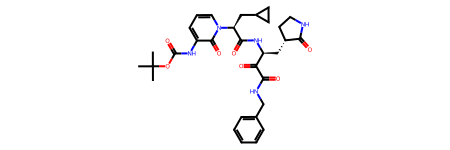

In [108]:
sars_cov_2

In [87]:
# from modules.molecular_graph import MolecularGraphDA

# Create molecular graphs DA
sars_cov_2_name = "SARS-CoV-2-IN-1; tert-butyl N-[1-[(2S)-1-[[(2S)-4-(benzylamino)-3,4-dioxo-1-[(3S)-2-oxopyrrolidin-3-yl]butan-2-yl]amino]-3-cyclopropyl-1-oxopropan-2-yl]-2-oxopyridin-3-yl]carbamate; tert-butyl N-(1-((2S)-1-(((2S)-4-(benzylamino)-3,4-dioxo-1-((3S)-2-oxopyrrolidin-3-yl)butan-2-yl)amino)-3-cyclopropyl-1-oxopropan-2-yl)-2-oxopyridin-3-yl)carbamate"
sars_2_cov_graph = MolecularGraphDA(molecule=sars_cov_2,
                                       mol_name=sars_cov_2_name)

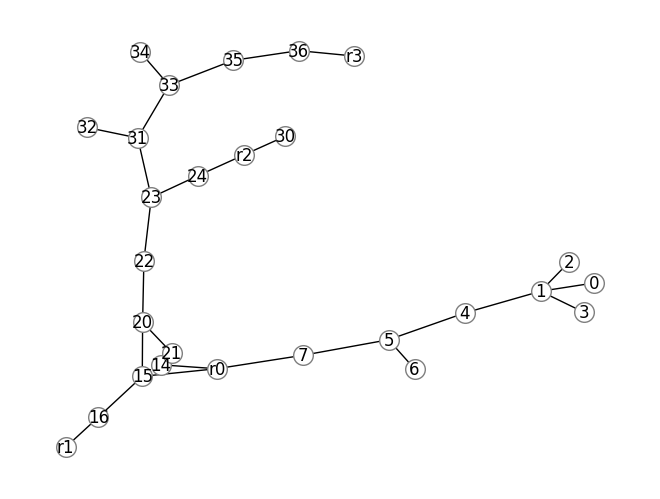

In [88]:
# import networkx as nx
# options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 1}
# nx.draw(sars_2_cov_graph.mol_graph, pos = nx.spring_layout(sars_2_cov_graph.mol_graph),node_color='white' ,with_labels=True, **options)

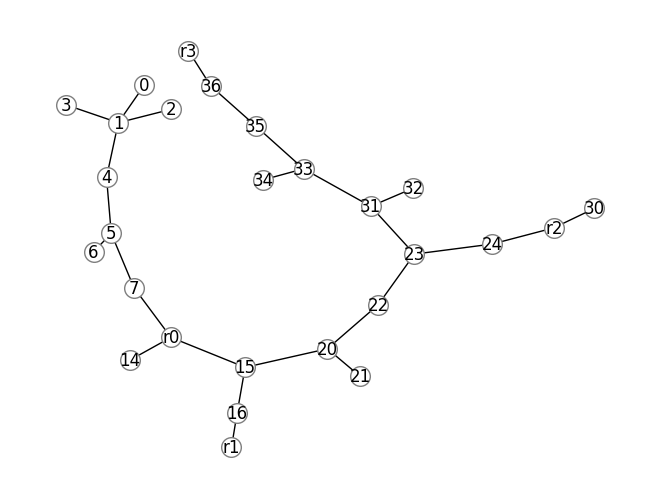

In [103]:
import networkx as nx
options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 1}
pos = nx.spring_layout(sars_2_cov_graph.mol_graph, seed=42)
nx.draw(sars_2_cov_graph.mol_graph, pos=pos,
        node_color='white', edgecolors='tab:gray',
        node_size=200, alpha=1, with_labels=True)

# Más limpio y legible para grafos complejos.

# Los nodos y aristas están bien distribuidos en el plano, sin solaparse.

# Siempre produce una vista 2D coherente y compacta.

# Las posiciones no tienen significado físico o químico.

# Los anillos o grupos funcionales no se ven como en la molécula real.

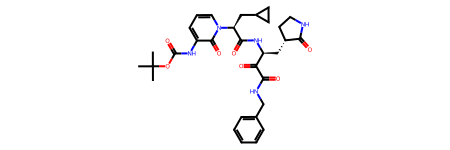

In [109]:
sars_cov_2

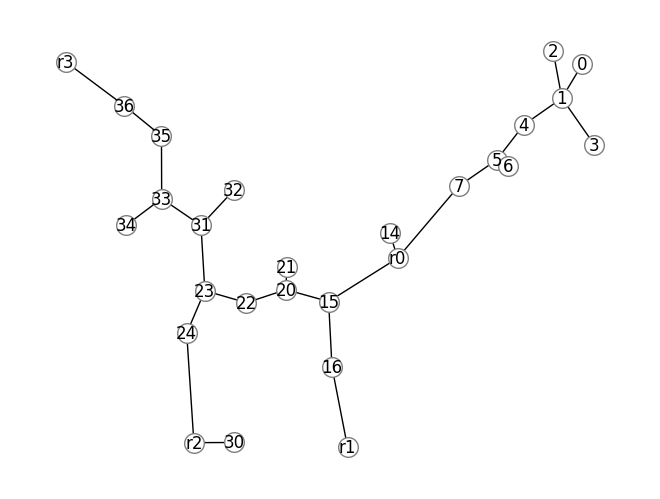

In [107]:
pos = {k: (v[0], v[1]) for k, v in sars_2_cov_graph.pos.items()}
nx.draw(sars_2_cov_graph.mol_graph, pos=pos,
        node_color='white', edgecolors='tab:gray',
        node_size=200, alpha=1, with_labels=True)

# nx.draw(sars_2_cov_graph.mol_graph,
#         pos=sars_2_cov_graph.pos,  
#         node_color='white',
#         edgecolors='tab:gray',
#         node_size=200,
#         alpha=1,
#         with_labels=True)

# Los nodos están en su posición real según RDKit (geometría molecular).

# Las distancias y ángulos entre átomos son físicamente significativos.

# Si has colapsado anillos, se ve la estructura química real (por ejemplo, anillos planos o grupos espaciales).

# A veces el dibujo en 2D queda apelmazado o desalineado, sobre todo si la molécula es tridimensional (p. ej. con puentes o torsiones).

# NetworkX solo usa 2D, así que se pierde información de profundidad (ejes Z).

# Menos legible si hay muchos nodos o enlaces superpuestos.

In [104]:
for node, coords in sars_2_cov_graph.pos.items():
    print(node, coords)

0 [ 8.74423705  3.93457544 -1.79952969]
1 [ 8.10404949  3.18788842 -0.62215922]
2 [7.82840581 4.22441288 0.42541152]
3 [ 9.12019351  2.16800218 -0.16222426]
4 [ 6.91888152  2.60771539 -1.09815834]
5 [ 6.0718479   1.84180627 -0.2722191 ]
6 [6.42663619 1.7051973  0.90462962]
7 [ 4.89287167  1.27157818 -0.77531779]
14 [ 2.73362281  0.25550098 -2.00986638]
15 [ 0.82950393 -1.24887444 -0.9924572 ]
16 [ 0.93582362 -2.68165627 -1.37728867]
20 [-0.49896071 -0.98989947 -0.37378724]
21 [-0.47924992 -0.50105585  0.78828036]
22 [-1.73139983 -1.274965   -1.06055876]
23 [-3.03012799 -1.01213988 -0.52250558]
24 [-3.59553134 -1.93992313  0.45663806]
30 [-2.11203317 -4.32454211 -1.43018932]
31 [-3.15073034  0.41209343 -0.05485878]
32 [-2.12893115  1.17753634 -0.09500564]
33 [-4.37600613  0.99663311  0.4489646 ]
34 [-5.48262893  0.41457038  0.52533394]
35 [-4.38259195  2.36316101  0.91633182]
36 [-5.5398218   3.02403617  1.42569602]
r0 [ 2.98340207 -0.30087246  0.53624309]
r1 [ 1.42217879 -4.43080816 -0

In [99]:
node_data = sars_2_cov_graph.mol_graph.nodes[1]
print(node_data)
atom = node_data['features']
print(atom.atomic_nb)        # Número atómico
print(atom.formal_charge)    # Carga formal
print(atom.is_donor)         # Si es donador
print(atom.is_aromatic)      # Si es aromático

{'features': <__main__.Atom object at 0x00000260D286BA50>}
6
0
False
False


In [59]:
# example_graph=list(sars_2_cov_graph.values())[0].graph

# for node,node_data in sars_2_cov_graph.nodes(data=True):
#     print(node,node_data)
# print('\n')

# # Access edges of a networkx graph
# print(sars_2_cov_graph.edges(data=True)) # Tuple with 3 elements: el0 is the node1, el1 is node2, el3 is the edge data (weight,confict type)
# for node1,node2,edge_data in sars_2_cov_graph.edges(data=True):
#     print(node1,node2,edge_data)

In [93]:
sars_2_cov_graph.mol_graph.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 14, 15, 16, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34, 35, 36, 'r0', 'r1', 'r2', 'r3'))

In [94]:
sars_2_cov_graph.mol_graph.edges()

EdgeView([(0, 1), (1, 2), (1, 3), (1, 4), (4, 5), (5, 6), (5, 7), (7, 'r0'), (14, 'r0'), (15, 16), (15, 20), (15, 'r0'), (16, 'r1'), (20, 21), (20, 22), (22, 23), (23, 24), (23, 31), (24, 'r2'), (30, 'r2'), (31, 32), (31, 33), (33, 34), (33, 35), (35, 36), (36, 'r3')])

In [95]:
for u, v, data in sars_2_cov_graph.mol_graph.edges(data=True):
    print(f"Arista {u}-{v}: tipo={data['bond_type']}, distancia={data['distance']:.2f} A")

Arista 0-1: tipo=SINGLE, distancia=1.53 A
Arista 1-2: tipo=SINGLE, distancia=1.50 A
Arista 1-3: tipo=SINGLE, distancia=1.51 A
Arista 1-4: tipo=SINGLE, distancia=1.40 A
Arista 4-5: tipo=SINGLE, distancia=1.41 A
Arista 5-6: tipo=DOUBLE, distancia=1.24 A
Arista 5-7: tipo=SINGLE, distancia=1.40 A
Arista 7-r0: tipo=SINGLE, distancia=2.80 A
Arista 14-r0: tipo=DOUBLE, distancia=2.62 A
Arista 15-16: tipo=SINGLE, distancia=1.49 A
Arista 15-20: tipo=SINGLE, distancia=1.49 A
Arista 15-r0: tipo=SINGLE, distancia=2.81 A
Arista 16-r1: tipo=SINGLE, distancia=2.11 A
Arista 20-21: tipo=DOUBLE, distancia=1.26 A
Arista 20-22: tipo=SINGLE, distancia=1.44 A
Arista 22-23: tipo=SINGLE, distancia=1.43 A
Arista 23-24: tipo=SINGLE, distancia=1.46 A
Arista 23-31: tipo=SINGLE, distancia=1.50 A
Arista 24-r2: tipo=SINGLE, distancia=2.41 A
Arista 30-r2: tipo=DOUBLE, distancia=2.47 A
Arista 31-32: tipo=DOUBLE, distancia=1.28 A
Arista 31-33: tipo=SINGLE, distancia=1.45 A
Arista 33-34: tipo=DOUBLE, distancia=1.25 A
Ari

In [70]:
list(sars_2_cov_graph.mol_graph.nodes(data=True))
list(sars_2_cov_graph.mol_graph.edges(data=True))

[(0, 1, {'distance': np.float64(1.5127555502754668), 'bond_type': 'SINGLE'}),
 (1, 2, {'distance': np.float64(1.4912301610744219), 'bond_type': 'SINGLE'}),
 (1, 3, {'distance': np.float64(1.5117568140715245), 'bond_type': 'SINGLE'}),
 (1, 4, {'distance': np.float64(1.4157578567162783), 'bond_type': 'SINGLE'}),
 (4, 5, {'distance': np.float64(1.3662901648889905), 'bond_type': 'SINGLE'}),
 (5, 6, {'distance': np.float64(1.2560407992973757), 'bond_type': 'DOUBLE'}),
 (5, 7, {'distance': np.float64(1.4159836536199433), 'bond_type': 'SINGLE'}),
 (7, 8, {'distance': np.float64(1.441626129439759), 'bond_type': 'SINGLE'}),
 (8, 9, {'distance': np.float64(1.3774288753774468), 'bond_type': 'AROMATIC'}),
 (8,
  13,
  {'distance': np.float64(1.3885908137008227), 'bond_type': 'AROMATIC'}),
 (9,
  10,
  {'distance': np.float64(1.3766550489912164), 'bond_type': 'AROMATIC'}),
 (10,
  11,
  {'distance': np.float64(1.3695850353753871), 'bond_type': 'AROMATIC'}),
 (11,
  12,
  {'distance': np.float64(1.3